In [6]:
import copy
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [182]:
def evaluate(X, y_cont, y_clf, model_reg, model_clf, score, score_clf='accuracy'):
    
    print('Cross-val-score, ' + score_clf + ': {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring=score_clf).mean()))
    
    model_clf.fit(X, y_clf)
    y_predicted = model_clf.predict(X)
    
    y1 = y_cont[y_predicted == 0]
    y2 = y_cont[y_predicted == 1]
    
    X1 = X[y_predicted == 0]
    X2 = X[y_predicted == 1]
    
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.7)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7)    
    
    X_train, y_train = pd.concat((X1_train, X2_train)), pd.concat((y1_train, y2_train))
    X_test, y_test = pd.concat((X1_test, X2_test)), pd.concat((y1_test, y2_test))
    
    model_reg.fit(X_train, y_train)
    print(score.__name__ + ' - исходная модель (test): {:.4f}'.format(score(model_reg.predict(X_test), y_test)), '\n',
         score.__name__ + ' - исходная модель (train): {:.4f}'.format(score(model_reg.predict(X_train), y_train))
         )
    
    model_reg_inside1 = copy.copy(model_reg)
    model_reg_inside2 = copy.copy(model_reg)
    
    model_reg_inside1.fit(X1_train, y1_train)
    model_reg_inside2.fit(X2_train, y2_train)
    
    yts = np.concatenate((model_reg_inside1.predict(X1_test), model_reg_inside2.predict(X2_test)))
    ytr = np.concatenate((model_reg_inside1.predict(X1_train), model_reg_inside2.predict(X2_train)))
    
    
    print(score.__name__ + ' - обработанная модель (test): {:.4f}'.format(score(yts, y_test)), '\n',
         score.__name__ + ' - обработанная модель (train): {:.4f}'.format(score(ytr, y_train)),
         )   

In [183]:
y19 = pd.cut(y1, [0, 1.19, np.inf], labels=[0, 1], include_lowest=True)

In [185]:
evaluate(M1, y1, y19, RandomForestRegressor(), RandomForestClassifier(), r2_score)

Cross-val-score, accuracy: 0.7962
r2_score - исходная модель (test): 0.9852 
 r2_score - исходная модель (train): 0.9972
r2_score - обработанная модель (test): 0.9889 
 r2_score - обработанная модель (train): 0.9980


In [155]:
from xgboost import XGBClassifier, XGBRegressor

In [156]:
evaluate(M1, y1, y19, XGBRegressor(), XGBClassifier(), r2_score)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cross-val-score, accuracy: 0.7591698470762654


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


r2_score - исходная модель: 0.9079862849841909
r2_score - обработанная модель: 0.9567341090497699


In [134]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
y[y == 2] = 0

In [135]:
evaluate(M1, y1, y, LinearRegression(), LogisticRegression(), r2_score)

Cross-val-score, accuracy: 0.37531736849266495
r2_score - исходная модель: 0.8223602913618112
r2_score - обработанная модель: -6.987304217687118e-05


In [7]:
def daytime(x):
        if x.hour >= 12 and x.hour <= 24:
            return 'Day'
        if x.hour > 0 and x.hour < 12:
            return 'Night'

In [8]:
def read_data():
    d1 = pd.read_csv('./d1.csv')
    d2 = pd.read_csv('./d2.csv')
    d1 = d1.dropna()
    d2 = d2.dropna(axis=1, thresh=5000) 
    d2.rename(columns={'P17': 'Удельные потери P17'}, inplace=True)
    return d1, d2

In [9]:
def preprocess(d1):
    d1['Стенд/Отжиг/Поз.  ВТО'] = d1['Стенд/Отжиг/Поз.  ВТО'].fillna('')
    d1 = pd.concat([d1, d1['Стенд/Отжиг/Поз.  ВТО'].apply(lambda x: pd.Series(x.split('/')), 1).rename(columns={0: 'Стенд', 1: 'Отжиг', 2: 'Поз.  ВТО'})], axis=1)
    d1.drop(columns='Отжиг', inplace=True)
    l = []
    
    for col in d1.columns:
        l.append(len(pd.unique(d1[col])))
    uniqness = pd.DataFrame({'name': d1.columns, 'len': l})
    d1.drop(columns=uniqness[uniqness['len'] == 1]['name'].values, inplace=True)

    d1['Daytime1'] = d1['Дата начала обработки'].apply(lambda x: daytime(pd.to_datetime(x)), 1)
    d1['Weekday1'] = d1['Дата начала обработки'].apply(lambda x: pd.to_datetime(x).weekday(), 1)

    d1['Daytime2'] = d1['Дата обработки АТОиП-5'].apply(lambda x: daytime(pd.to_datetime(x)), 1)
    d1['Weekday2'] = d1['Дата обработки АТОиП-5'].apply(lambda x: pd.to_datetime(x).weekday(), 1)

    cat_columns = list(uniqness[uniqness['len'] <= 16]['name'].values) + \
    ['Партия АНО ПДС', '№ партии АТОиП№5', 'Дата обработки АТОиП-5', 'Дата начала обработки', 'Daytime1', 'Weekday1', 'Daytime2', 'Weekday2']
    cat_columns
    
    y = d1['Удельные потери P17']
    X = d1.drop(columns=['Удельные потери P17'])
    
    M = pd.get_dummies(X, columns=list(set(cat_columns).intersection(set(d1.columns))))
    return M, y

In [10]:
d1, d2 = read_data()
M1, y1 = preprocess(d1)
M2, y2 = preprocess(d2)
M1.drop(columns=['Стенд/Отжиг/Поз.  ВТО', 'Р17ср'], inplace=True)

In [11]:
lr = LinearRegression()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(M1, y1, train_size=0.7)

In [13]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
r2_score(lr.predict(X_test), y_test)

0.8216629681036802

In [16]:
mse(lr.predict(X_test), y_test)

0.003424057836996756

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
y[y==2] = 0
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.7)

In [53]:
lr_clf = LogisticRegression()

In [54]:
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
accuracy_score(lr_clf.predict(X_test), y_test)

0.6925984468421414

### Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [34]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
y[y==2] = 0
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.7)

In [47]:
rf = RandomForestClassifier(n_estimators=20,)

In [48]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
accuracy_score(rf.predict(X_train), y_train)

0.9980560791705938

In [43]:
l = lgb.LGBMClassifier(max_depth=20)

In [44]:
l.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=20,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [45]:
accuracy_score(l.predict(X_train), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8789762016965127

### XGB

In [113]:
from xgboost import XGBClassifier, XGBRegressor

In [114]:
xgb = XGBClassifier(max_depth=10)

In [115]:
y = pd.cut(y1, [0, 1.19, np.inf], include_lowest=True, labels=[0, 1])

In [116]:
xgb.fit(M1, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [117]:
accuracy_score(xgb.predict(X_train), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9999742281325705

In [118]:
accuracy_score(xgb.predict(X_test), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9997938356870426

In [127]:
predictions = xgb.predict(M1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [132]:
xgbreg_0 = XGBRegressor(max_depth=10, )

In [136]:
X_0 = M1[predictions == 0]
y_0 = y1[predictions == 0]
X_1 = M1[predictions == 1]
y_1 = y1[predictions == 1]

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, train_size=0.7)

In [138]:
xgbreg_0.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [142]:
print(r2_score(xgbreg_0.predict(X_train), y_train))
print(r2_score(xgbreg_0.predict(X_test), y_test))

0.9940847447078055
0.9777507208923486


In [146]:
std_0 = y_0.std()

In [147]:
print(mse(xgbreg_0.predict(X_train), y_train)/std_0)
print(mse(xgbreg_0.predict(X_test), y_test)/std_0)

0.0004361535300901298
0.0016304147415726364


In [148]:
xgbreg = XGBRegressor(max_depth=10)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(M1, y1, train_size=0.7)

In [156]:
xgbreg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [158]:
mse(xgbreg.predict(X_test), y_test)/std

0.03542898247878967

In [162]:
M1.corrwith(y1).sort_values()

№ плавки_1717431                             -0.342994
Азот_0.0077                                  -0.342994
Титан_0.003                                  -0.342994
Кремний_3.3310000000000004                   -0.342994
Углерод_0.054000000000000006                 -0.342994
Weekday2_5                                   -0.328720
Nк_0.023                                     -0.311614
Nн_0.022000000000000002                      -0.308482
№ Стенда_139                                 -0.308081
Стенд_139                                    -0.308081
№ Колпака_140                                -0.308081
№ Отжига_430                                 -0.308081
Тренд температуры конца прокатки (М12-02)    -0.290843
Фосфор_0.024                                 -0.274371
Nсреднее_0.0225                              -0.268095
Nсреднее_0.022000000000000002                -0.267017
Партия АНО ПДС_580817                        -0.255896
Дата обработки АТОиП-5_2017-08-26 09:15:12   -0.255896
№ партии А

### Peaks classification

In [110]:
y = pd.cut(y1, [0, 1.19, np.inf], include_lowest=True, labels=[0, 1])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.8)

In [83]:
pclass = lgb.LGBMClassifier()
pclass.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [84]:
predictions = pclass.predict(M1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [85]:
accuracy_score(predictions, y)

0.9983300002061728

In [52]:
import seaborn as sns

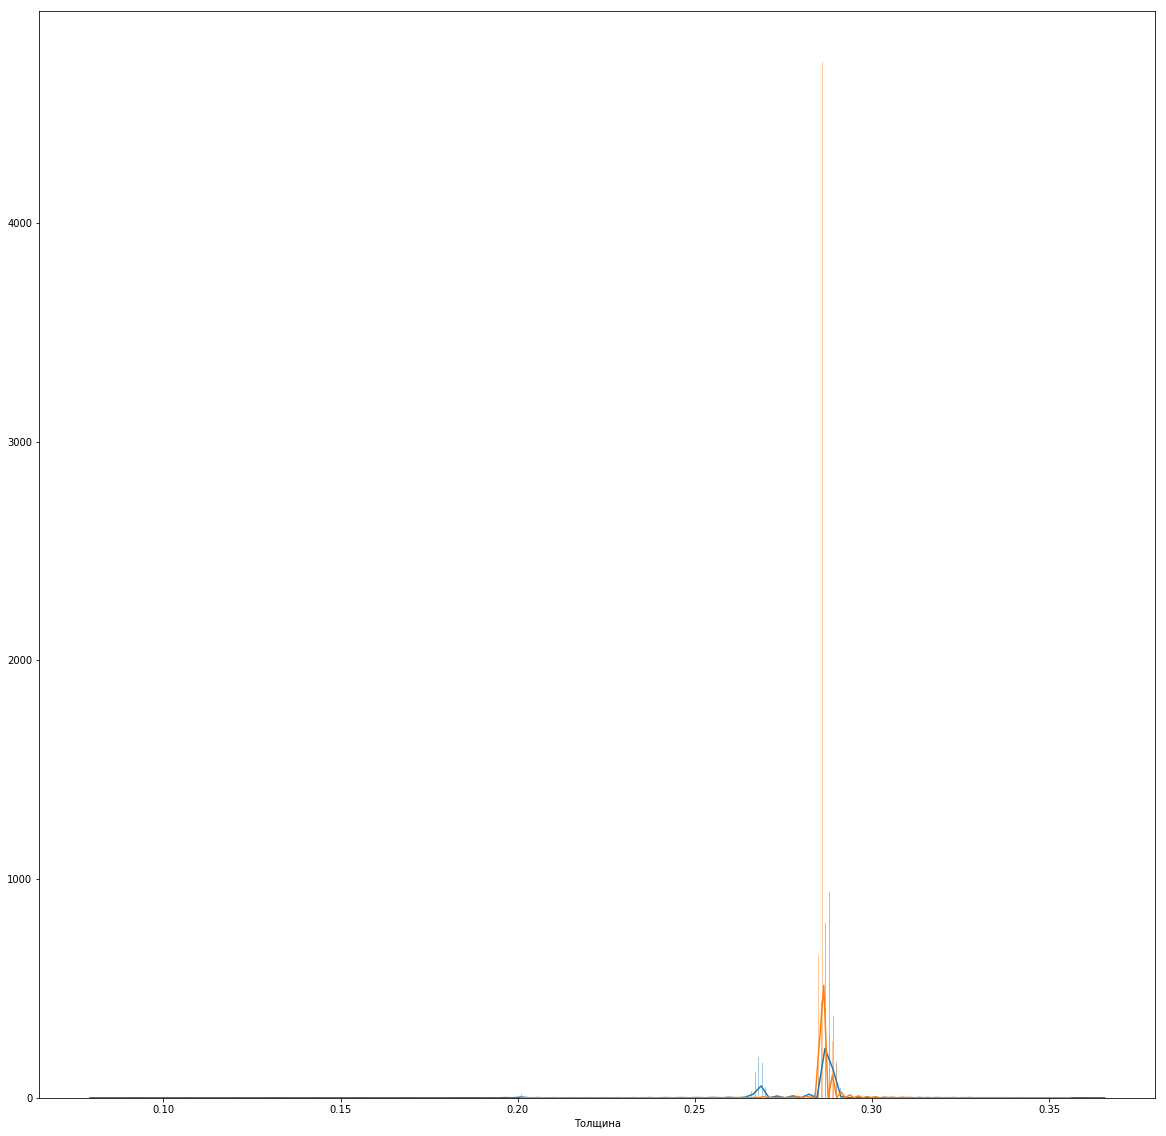

In [58]:
plt.figure(figsize=(20, 20))
sns.distplot(M1[y == 0]['Толщина'], bins=1000)
sns.distplot(M1[y == 1]['Толщина'], bins=1000)

In [74]:
new = pd.concat((M1, pd.Series(y1, name='Потери'), y), axis=1)

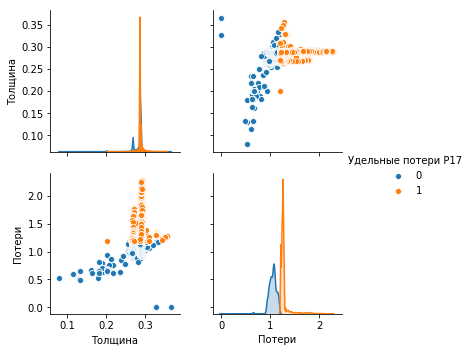

In [79]:
sns.pairplot(new, hue='Удельные потери P17', vars=['Толщина', 'Потери'], )

In [86]:
first = M1[predictions==0]
y11 = y1[predictions==0]
second = M1[predictions==1]
y22 = y1[predictions==1]

In [95]:
std = M1[y == 0]['Толщина'].std()

In [97]:
reg = lgb.LGBMRegressor()
X_train, X_test, y_train, y_test = train_test_split(first, y11, train_size=0.7 )
reg.fit(X_train, y_train)
r2_score(reg.predict(X_test), y_test)
print(mse(reg.predict(X_test), y_test)/std)

0.03957280764191099


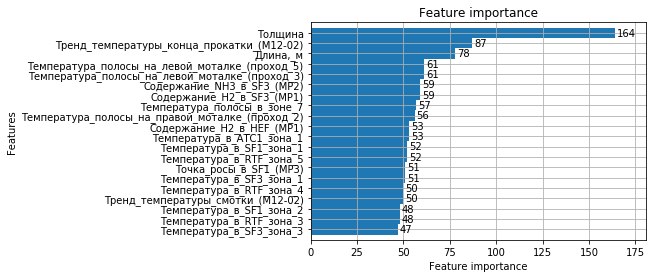

In [14]:
lgb.plot_importance(reg, max_num_features=20, height=1)

In [98]:
reg = lgb.LGBMRegressor()
X_train, X_test, y_train, y_test = train_test_split(second, y22, train_size=0.7 )
reg.fit(X_train, y_train)
r2_score(reg.predict(X_test), y_test)
print(mse(reg.predict(X_test), y_test)/std)

0.03302031910716914


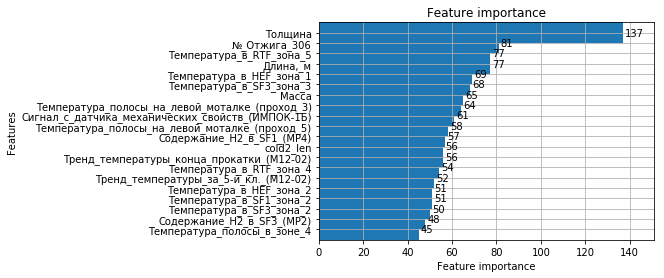

In [20]:
lgb.plot_importance(pclass, max_num_features=20, height=2)

### Whole regression 

In [99]:
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.7 )

In [100]:
whole_reg = lgb.LGBMRegressor()

In [101]:
whole_reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [12]:
r2_score(whole_reg.predict(X_test), y_test)

0.9789924742186783

In [102]:
mse(whole_reg.predict(X_test), y_test)/std

0.3938777120319277

Only width

In [21]:
fat = lgb.LGBMClassifier()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.8)
fat.fit(np.array(X_train['Толщина']).reshape(-1, 1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
accuracy_score(fat.predict(np.array(X_test['Толщина']).reshape(-1, 1)), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8484692299762912

### Regression between peaks

In [144]:
below = M1[y1 <= 1.19]
y_below = y1[y1 <= 1.19]
under = M1[y1 > 1.19]
y_under = y1[y1 > 1.19]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(below, y_below, train_size=0.8)
rbelow = lgb.LGBMRegressor()
rbelow.fit(X_train, y_train)

In [149]:
r2_score(rbelow.predict(X_test), y_test)

0.9467821578041674

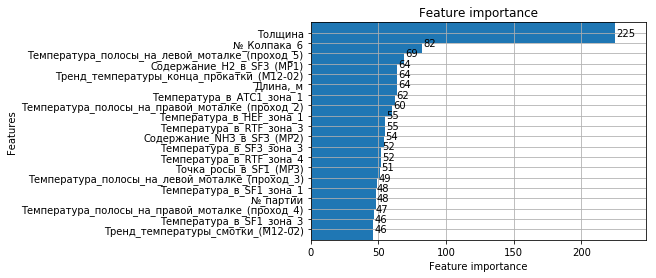

In [150]:
lgb.plot_importance(rbelow, max_num_features=20, height=2)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(under, y_under, train_size=0.8)

In [153]:
runder = lgb.LGBMRegressor()
runder.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [155]:
r2_score(runder.predict(X_test), y_test)

0.9729102176469872

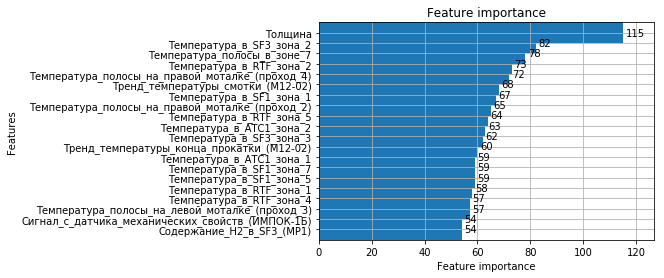

In [156]:
lgb.plot_importance(runder, max_num_features=20, height=2)

#### WIthout width

In [158]:
below = M1.drop(columns='Толщина')[y1 <= 1.19]
y_below = y1[y1 <= 1.19]
under = M1.drop(columns='Толщина')[y1 > 1.19]
y_under = y1[y1 > 1.19]

In [159]:
X_train, X_test, y_train, y_test = train_test_split(below, y_below, train_size=0.8)
rbelow = lgb.LGBMRegressor()
rbelow.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [160]:
r2_score(rbelow.predict(X_test), y_test)

0.8740714576626056

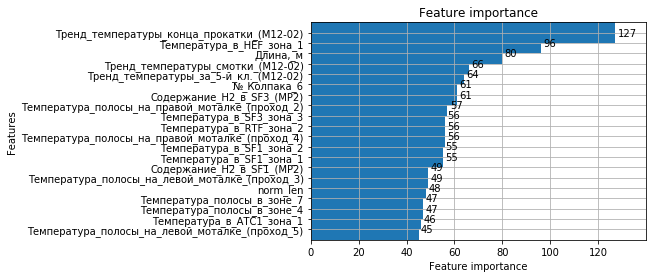

In [161]:
lgb.plot_importance(rbelow, max_num_features=20, height=2)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(under, y_under, train_size=0.8)

In [166]:
runder = lgb.LGBMRegressor()
runder.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [167]:
r2_score(runder.predict(X_test), y_test)

0.9682647949361932

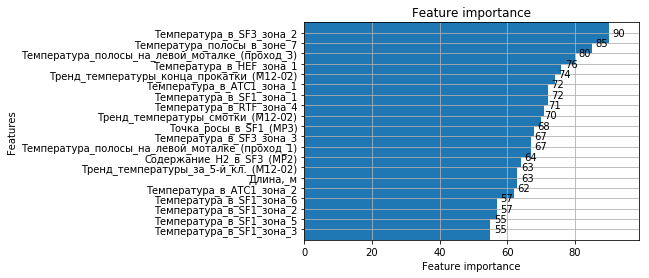

In [168]:
lgb.plot_importance(runder, max_num_features=20, height=2)

### Binary classification 

In [20]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], include_lowest=True, labels=[0, 1, 2])

In [22]:
y[y==2]= 0

In [24]:
y.value_counts()

1    27213
0    21290
2        0
Name: Удельные потери P17, dtype: int64

In [27]:
y1.head()

742    1.246
743    1.271
744    1.260
745    1.263
746    1.273
Name: Удельные потери P17, dtype: float64

In [28]:
y.head()

742    1
743    0
744    1
745    0
746    0
Name: Удельные потери P17, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [29]:
clf = lgb.LGBMClassifier()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.7)

In [41]:
from sklearn.metrics import precision_score, recall_score

In [42]:
clf.fit(X_train, y_train)

print('Test accuracy score is {}'.format(accuracy_score(clf.predict(X_test), y_test)))
print('Test f1 score is {}'.format(f1_score(clf.predict(X_test), y_test)))
print('Test precision score is {}'.format(precision_score(clf.predict(X_test), y_test)))
print('Test recall score is {}'.format(recall_score(clf.predict(X_test), y_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test accuracy score is 0.8510755274551577
Test f1 score is 0.871813073055309
Test precision score is 0.9025107164727495
Test recall score is 0.8431350114416476


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
print('Train accuracy score is {}'.format(accuracy_score(clf.predict(X_train), y_train)))
print('Train f1 score is {}'.format(f1_score(clf.predict(X_train), y_train)))
print('Test precision score is {}'.format(precision_score(clf.predict(X_train), y_test)))
print('Test recall score is {}'.format(recall_score(clf.predict(X_test), y_test)))

Train accuracy score is 0.8749705466540999
Train f1 score is 0.8923981648120454


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### PCA

In [172]:
pca = PCA(n_components=10)

In [173]:
new_M = pca.fit_transform(M1)

In [182]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
X_train, X_test, y_train, y_test = train_test_split(new_M, y, train_size=0.8)

In [184]:
pca_cl = lgb.LGBMClassifier()
pca_cl.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [189]:
accuracy_score(pca_cl.predict(X_train), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8570434513684861

In [187]:
accuracy_score(pca_cl.predict(X_test), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8386764251108133

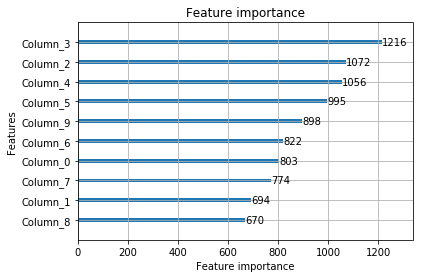

In [190]:
lgb.plot_importance(pca_cl)

In [197]:
np.argmax(pca.components_[3])

67